# TP2 - CLASE 3

## 1. Medición de foco en toda la imagen

### Objetivo:
Implementar un detector de máximo enfoque sobre un video aplicando técnicas de análisis espectral similar al que utilizan las cámaras digitales modernas. El video a procesar será: **focus_video.mov**.

Se debe implementar un algoritmo que dada una imagen, o región, calcule la métrica propuesta en el paper **"Image Sharpness Measure for Blurred Images in Frequency Domain"** y realizar tres experimentos:

1. **Medición sobre todo el frame.**
2. **Medición sobre una ROI ubicada en el centro del frame.** Área de la ROI = 5 o 10% del área total del frame.

### Opcional:
1. **Medición sobre una matriz de enfoque** compuesta por un arreglo de NxM elementos rectangulares equiespaciados. N y M son valores arbitrarios, probar con varios valores 3x3, 7x5, etc. (al menos 3)

### Para cada experimento se debe presentar:
- Una curva o varias curvas que muestren la evolución de la métrica frame a frame donde se vea claramente cuando el algoritmo detectó el punto de máximo enfoque.

In [2]:
#Libraries
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# open video file and extract metadata
video_path = "data/focus_video.mov"

if os.path.exists(video_path):
    cap = cv2.VideoCapture(video_path)
    
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = cap.get(cv2.CAP_PROP_FPS)
    duration = frame_count / fps if fps > 0 else 0
    
    video_info = {
        'frames': frame_count,
        'resolution': f"{width}x{height}",
        'width': width,
        'height': height,
        'fps': fps,
        'duration_seconds': duration,
        'codec': int(cap.get(cv2.CAP_PROP_FOURCC))
    }
    
    cap.release()
    
    for key, value in video_info.items():
        if key == 'codec':
            codec_str = ''.join([chr((value >> 8 * i) & 0xFF) for i in range(4)])
            print(f"{key}: {codec_str}")
        elif key == 'duration_seconds':
            print(f"{key}: {value:.2f}")
        elif key == 'fps':
            print(f"{key}: {value:.2f}")
        else:
            print(f"{key}: {value}")
            
else:
    print(f"Video file not found: {video_path}")

frames: 171
resolution: 640x360
width: 640
height: 360
fps: 29.97
duration_seconds: 5.71
codec: h264


In [4]:
# create a video showing the Fourier transform of each frame
os.makedirs("outputs", exist_ok=True)

input_path = "data/focus_video.mov"
output_path = "outputs/fourier_transform_video.mp4"

cap = cv2.VideoCapture(input_path)
frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = cap.get(cv2.CAP_PROP_FPS)

fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

for i in range(frame_count):
    ret, frame = cap.read()
    if not ret:
        break
    
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    
    f_transform = np.fft.fft2(gray)
    f_shift = np.fft.fftshift(f_transform)
    magnitude_spectrum = np.log(np.abs(f_shift) + 1)
    
    magnitude_normalized = cv2.normalize(magnitude_spectrum, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
    magnitude_bgr = cv2.cvtColor(magnitude_normalized, cv2.COLOR_GRAY2BGR)
    
    out.write(magnitude_bgr)

cap.release()
out.release()

print(f"Fourier transform video saved to: {output_path}")

Fourier transform video saved to: outputs/fourier_transform_video.mp4


3. Proposed Algorithm for calculating Image Quality measure
3.1 Algorithm for image quality measure
Input: Image I of size M×N.
Output: Image Quality measure (FM) where FM stands for Frequency Domain Image Blur Measure
Step 1: Compute F which is the Fourier Transform representation of image I
Step 2: Find Fc which is obtained by shifting the origin of F to centre.
Step 3: Calculate AF = abs (Fc) where AF is the absolute value of the centered Fourier transform of image I.
Step 4: Calculate M = max (AF) where M is the maximum value of the frequency component in F.
Step 5: Calculate TH = the total number of pixels in F whose pixel value > thres, where thres = M/1000.
Step 6: Calculate Image Quality measure (FM) from equation (1).
FM = TH / (M * N) (1)

In [5]:
def calculate_image_quality(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    f_transform = np.fft.fft2(gray)
    f_shift = np.fft.fftshift(f_transform)
    magnitude_spectrum = np.abs(f_shift)
    
    M = np.max(magnitude_spectrum)
    thres = M / 1000
    TH = np.sum(magnitude_spectrum > thres)
    N = image.shape[0] * image.shape[1]
    
    FM = TH / (M * N) if M * N != 0 else 0
    return FM

In [6]:
input_path = "data/focus_video.mov"
cap = cv2.VideoCapture(input_path)
quality_scores = []
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break
    quality = calculate_image_quality(frame)
    quality_scores.append(quality)
cap.release()


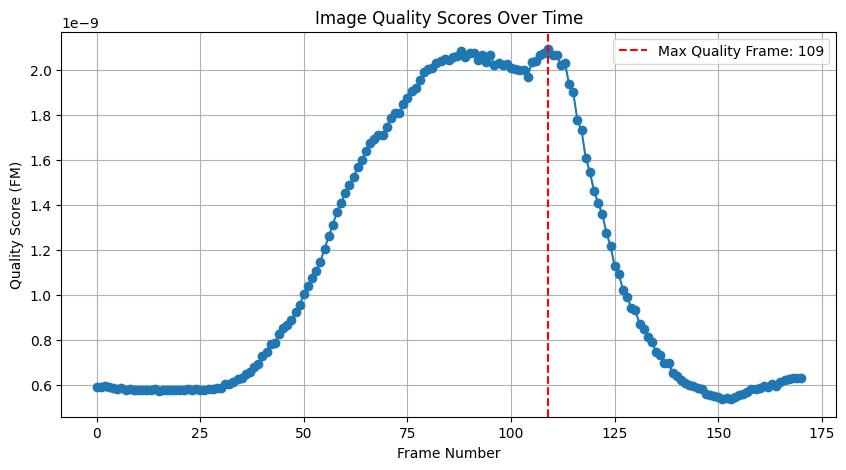

Max quality score: 0.000000 at frame 109


In [7]:
# Plot quality scores over time
max = np.argmax(quality_scores) if quality_scores else 0
plt.figure(figsize=(10, 5))
plt.plot(quality_scores, marker='o')
plt.axvline(x=max, color='r', linestyle='--', label=f'Max Quality Frame: {max}')
plt.title('Image Quality Scores Over Time')
plt.xlabel('Frame Number')
plt.ylabel('Quality Score (FM)')
plt.legend()
plt.grid()
plt.show()
print(f"Max quality score: {quality_scores[max]:.6f} at frame {max}")

In [8]:
def calculate_image_quality_roi(image, porcentage_roi=0.05):
    im=image.copy()
    h, w, _ = im.shape
    roi_h, roi_w = int(h * porcentage_roi), int(w * porcentage_roi)
    start_h, start_w = (h - roi_h) // 2, (w - roi_w) // 2
    roi = im[start_h:start_h + roi_h, start_w:start_w + roi_w]
    FM=calculate_image_quality(roi)
    
    return FM

In [9]:
input_path = "data/focus_video.mov"
cap = cv2.VideoCapture(input_path)
quality_scores_5p = []
quality_scores_10p = []
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break
    quality_5p = calculate_image_quality_roi(frame, porcentage_roi=0.05)
    quality_scores_5p.append(quality_5p)
    quality_10p = calculate_image_quality_roi(frame, porcentage_roi=0.10)
    quality_scores_10p.append(quality_10p)
cap.release()

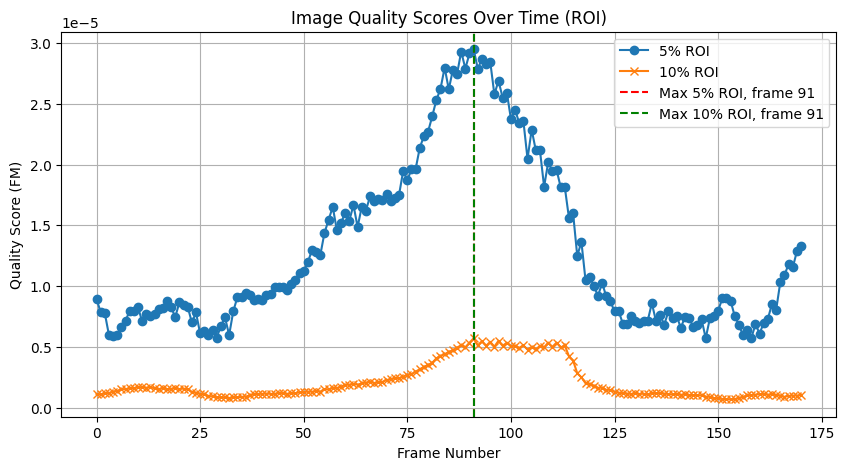

Max quality score (5% ROI): 0.000029 at frame 91
Max quality score (10% ROI): 0.000006 at frame 91


In [10]:
# Plot quality scores ROI over time and the max value
max_5p = np.argmax(quality_scores_5p) if quality_scores_5p else 0
max_10p = np.argmax(quality_scores_10p) if quality_scores_10p else 0
plt.figure(figsize=(10, 5))
plt.plot(quality_scores_5p, marker='o', label='5% ROI')
plt.plot(quality_scores_10p, marker='x', label='10% ROI')
plt.axvline(x=max_5p, color='r', linestyle='--', label=f'Max 5% ROI, frame {max_5p}' if quality_scores_5p else '')
plt.axvline(x=max_10p, color='g', linestyle='--', label=f'Max 10% ROI, frame {max_10p}' if quality_scores_10p else '')
plt.title('Image Quality Scores Over Time (ROI)')
plt.xlabel('Frame Number')
plt.ylabel('Quality Score (FM)')
plt.legend()
plt.grid()
plt.show()
print(f"Max quality score (5% ROI): {quality_scores_5p[max_5p]:.6f} at frame {max_5p}")
print(f"Max quality score (10% ROI): {quality_scores_10p[max_10p]:.6f} at frame {max_10p}")

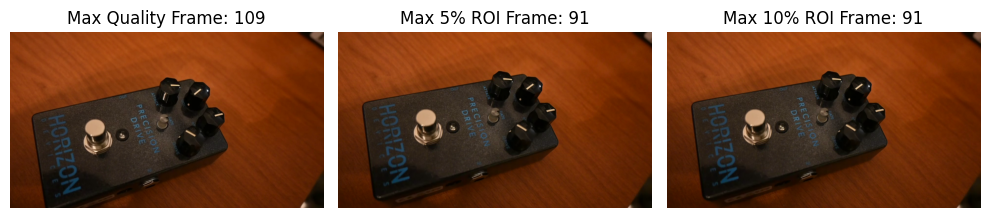

In [11]:
# Plot the max quality frame for all the algorithms
max = np.argmax(quality_scores) if quality_scores else 0
max_5p = np.argmax(quality_scores_5p) if quality_scores_5p else 0
max_10p = np.argmax(quality_scores_10p) if quality_scores_10p else 0
input_path = "data/focus_video.mov"
cap = cv2.VideoCapture(input_path)
quality_scores_5p = []
quality_scores_10p = []
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break
    if cap.get(cv2.CAP_PROP_POS_FRAMES) - 1 == max:
        max_frame = frame.copy()
    if cap.get(cv2.CAP_PROP_POS_FRAMES) - 1 == max_5p:
        max_frame_5p = frame.copy()
    if cap.get(cv2.CAP_PROP_POS_FRAMES) - 1 == max_10p:
        max_frame_10p = frame.copy()
cap.release()
plt.figure(figsize=(10, 5))
plt.subplot(1, 3, 1)
plt.imshow(cv2.cvtColor(max_frame, cv2.COLOR_BGR2RGB))
plt.title(f'Max Quality Frame: {max}')
plt.axis('off')
plt.subplot(1, 3, 2)
plt.imshow(cv2.cvtColor(max_frame_5p, cv2.COLOR_BGR2RGB))
plt.title(f'Max 5% ROI Frame: {max_5p}')
plt.axis('off')
plt.subplot(1, 3, 3)
plt.imshow(cv2.cvtColor(max_frame_10p, cv2.COLOR_BGR2RGB))
plt.title(f'Max 10% ROI Frame: {max_10p}')
plt.axis('off')
plt.tight_layout()
plt.show()

In [12]:
def calculate_image_quality_matrix(image, matrix_size=(3, 3)):
    rows, cols = matrix_size
    h, w = image.shape[:2]
    
    cell_h = h // rows
    cell_w = w // cols
    
    quality_matrix = np.zeros((rows, cols))
    
    for i in range(rows):
        for j in range(cols):
            start_h = i * cell_h
            end_h = start_h + cell_h if i < rows - 1 else h
            start_w = j * cell_w
            end_w = start_w + cell_w if j < cols - 1 else w
            
            cell = image[start_h:end_h, start_w:end_w]
            quality_matrix[i, j] = calculate_image_quality(cell)
    
    return quality_matrix

In [13]:
input_path = "data/focus_video.mov"
cap = cv2.VideoCapture(input_path)

matrix_sizes = [(3, 3), (5, 7), (7, 5)]
quality_scores_matrix = {str(size): [] for size in matrix_sizes}

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break
    
    for matrix_size in matrix_sizes:
        quality_matrix = calculate_image_quality_matrix(frame, matrix_size)
        avg_quality = np.mean(quality_matrix)
        quality_scores_matrix[str(matrix_size)].append(avg_quality)

cap.release()


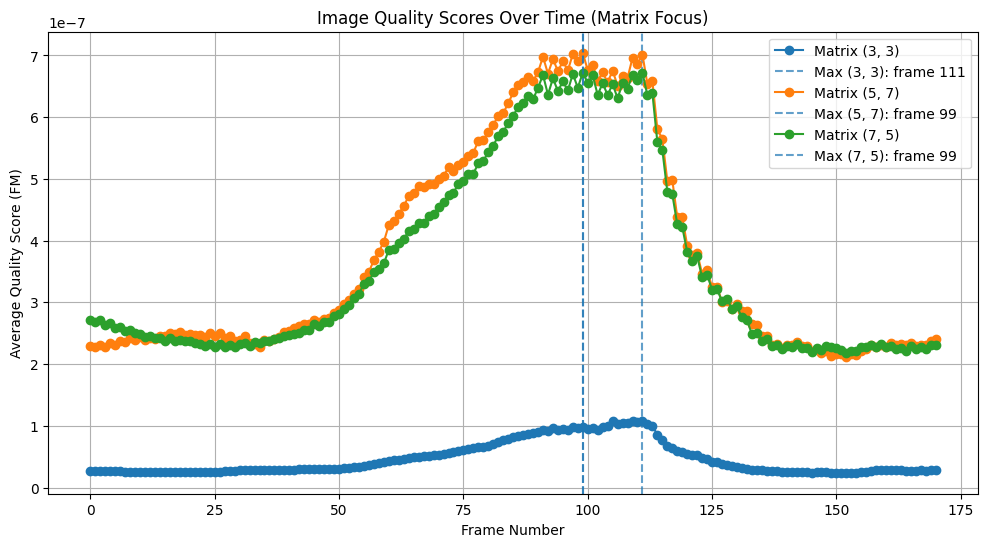

Matrix (3, 3) - Max quality: 0.000000 at frame 111
Matrix (5, 7) - Max quality: 0.000001 at frame 99
Matrix (7, 5) - Max quality: 0.000001 at frame 99


In [14]:
plt.figure(figsize=(12, 6))
for i, (matrix_size, scores) in enumerate(quality_scores_matrix.items()):
    max_idx = np.argmax(scores) if scores else 0
    plt.plot(scores, marker='o', label=f'Matrix {matrix_size}')
    plt.axvline(x=max_idx, linestyle='--', alpha=0.7, label=f'Max {matrix_size}: frame {max_idx}')

plt.title('Image Quality Scores Over Time (Matrix Focus)')
plt.xlabel('Frame Number')
plt.ylabel('Average Quality Score (FM)')
plt.legend()
plt.grid()
plt.show()

for matrix_size, scores in quality_scores_matrix.items():
    if scores:
        max_idx = np.argmax(scores)
        print(f"Matrix {matrix_size} - Max quality: {scores[max_idx]:.6f} at frame {max_idx}")

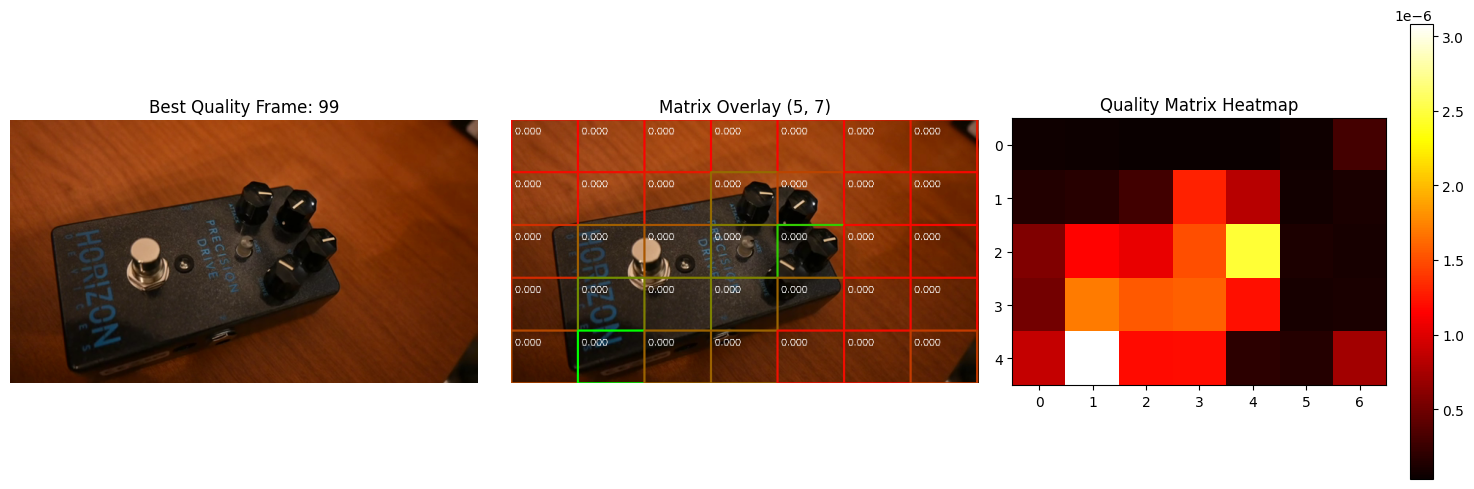

In [15]:
def visualize_matrix_overlay(image, matrix_size, quality_matrix):
    h, w = image.shape[:2]
    rows, cols = matrix_size
    cell_h = h // rows
    cell_w = w // cols
    
    overlay = image.copy()
    
    for i in range(rows):
        for j in range(cols):
            start_h = i * cell_h
            end_h = start_h + cell_h
            start_w = j * cell_w
            end_w = start_w + cell_w
            
            if end_h > h:
                end_h = h
            if end_w > w:
                end_w = w
            
            quality_val = quality_matrix[i, j]
            max_quality = np.max(quality_matrix)
            
            intensity = int(255 * (quality_val / max_quality)) if max_quality > 0 else 0
            color = (0, intensity, 255 - intensity)
            
            cv2.rectangle(overlay, (start_w, start_h), (end_w, end_h), color, 2)
            cv2.putText(overlay, f'{quality_val:.3f}', (start_w + 5, start_h + 20), 
                       cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255, 255, 255), 1)
    
    return overlay

best_score = 0
best_matrix_size = None
for matrix_key, scores in quality_scores_matrix.items():
    if scores and np.max(scores) > best_score:
        best_score = np.max(scores)
        best_matrix_size = matrix_key

best_frame_idx = np.argmax(quality_scores_matrix[best_matrix_size]) if best_matrix_size else 0

cap = cv2.VideoCapture(input_path)
cap.set(cv2.CAP_PROP_POS_FRAMES, best_frame_idx)
ret, best_frame = cap.read()
cap.release()

if ret:
    matrix_size = eval(best_matrix_size)
    quality_matrix = calculate_image_quality_matrix(best_frame, matrix_size)
    overlay_image = visualize_matrix_overlay(best_frame, matrix_size, quality_matrix)
    
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.imshow(cv2.cvtColor(best_frame, cv2.COLOR_BGR2RGB))
    plt.title(f'Best Quality Frame: {best_frame_idx}')
    plt.axis('off')
    
    plt.subplot(1, 3, 2)
    plt.imshow(cv2.cvtColor(overlay_image, cv2.COLOR_BGR2RGB))
    plt.title(f'Matrix Overlay {matrix_size}')
    plt.axis('off')
    
    plt.subplot(1, 3, 3)
    plt.imshow(quality_matrix, cmap='hot', interpolation='nearest')
    plt.title('Quality Matrix Heatmap')
    plt.colorbar()
    
    plt.tight_layout()
    plt.show()

## 2. Cambiar la métrica de enfoque
Eligiendo uno de los algoritmos explicados en el apéndice de: **"Analysis of focus measure operators in shape from focus"**.

El algoritmo de detección a implementar debe detectar y devolver los puntos de máximo enfoque de manera automática.

### Resultados esperados:
- Matriz de enfoque superpuesta a uno de los frames del video
- Gráfico de la métrica asociado al experimento

### Puntos extra:
Aplicar unsharp masking para expandir la zona de enfoque y recalcular la métrica.

Analizando las conclusiones del paper **"Analysis of focus measure operators in shape from focus"** vemos que el mejor operador para medir el enfoque cuando hay ruido gauseano es el gray-level variance (STA3, en el paper) que sufre poco al aumentar el ruido.
En cambio el mejor operador en generel es el Laplacian modificado (LAP2 en el paper). Este operador es sensible al ruido por que realiza una segunda derivada, pero es el que mejor resultados da en condiciones ideales.
Por lo explicado anteriormente se van a implementar ambos y comparar resultados para nuestro video.

## 1. Operador (Varianza - STA3)

STA3(i, j) = (1 / N) * SUM((x, y) en W_i,j) [ (I(x, y) - mu_i,j) ^ 2 ]
mu_i,j = (1 / N) * SUM((x, y) en W_i,j) [ I(x, y) ]


## 2. Operador (Laplaciano Modificado - LAP2)
LAP2(x, y) = SUM((i, j) en W_x,y) [ DmI(i, j) ]
DmI(i, j) = | I * LX | + | I * LY |


In [ ]:
def calculate_sta3_focus_measure(image, window_size=3):
    """
    Implementa el operador STA3 (Gray-level Variance) para medir el enfoque
    """
    if len(image.shape) == 3:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray = image.copy()
    
    gray = gray.astype(np.float32)
    h, w = gray.shape
    t = window_size
    half_t = t // 2
    
    focus_map = np.zeros((h, w), dtype=np.float32)
    
    for i in range(half_t, h - half_t):
        for j in range(half_t, w - half_t):
            
            suma_pixeles = 0
            n = t * t
            
            # Calcular la media de la ventana
            for x in range(i - half_t, i + half_t + 1):
                for y in range(j - half_t, j + half_t + 1):
                    suma_pixeles += gray[x, y]
            
            media_ventana = suma_pixeles / n
            
            # Calcular la varianza de la ventana
            suma_diferencias_cuadradas = 0
            for x in range(i - half_t, i + half_t + 1):
                for y in range(j - half_t, j + half_t + 1):
                    diferencia = gray[x, y] - media_ventana
                    suma_diferencias_cuadradas += diferencia * diferencia
            
            varianza_sta3 = suma_diferencias_cuadradas / n
            focus_map[i, j] = varianza_sta3
    
    return focus_map

def max_focus_points(focus_map):
    """funcion que obtiene los pixeles de maximo foco"""
    max_value = np.max(focus_map)
    
    max_positions = np.where(focus_map == max_value)
    
    max_points = list(zip(max_positions[0], max_positions[1]))
    
    return max_points, max_value

def create_focus_points_video(input_path, output_path, window_size=3):
    """
    Genera un video que muestra los puntos de máximo enfoque superpuestos al video original
    """
    cap = cv2.VideoCapture(input_path)
    
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = cap.get(cv2.CAP_PROP_FPS)
    
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))
    
    print(f"Procesando {frame_count} frames...")
    
    for frame_idx in range(frame_count):
        ret, frame = cap.read()
        if not ret:
            break
        
        focus_map = calculate_sta3_focus_measure(frame, window_size)
        max_points, max_value = max_focus_points(focus_map)
        
        output_frame = frame.copy()
        

        for point in max_points:
            row, col = point
            cv2.circle(output_frame, (col, row), 5, (0, 0, 255), -1)
            cv2.circle(output_frame, (col, row), 15, (0, 0, 255), 2)
        
        text = f'Frame: {frame_idx} | Max Focus: {max_value:.2f} | Points: {len(max_points)}'
        cv2.putText(output_frame, text, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2)
        cv2.putText(output_frame, text, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 0), 1)

        out.write(output_frame)
        
    
    cap.release()
    out.release()
    
    print(f"Video con puntos de enfoque guardado en: {output_path}")
    return output_path



In [ ]:
input_video = "data/focus_video.mov"
output_video = "outputs/focus_points_video.mp4"

create_focus_points_video(input_video, output_video, window_size=3)

Procesando 171 frames...
Video con puntos de enfoque guardado en: outputs/focus_points_video.mp4
Video con puntos de enfoque guardado en: outputs/focus_points_video.mp4


'outputs/focus_points_video.mp4'